https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

In [3]:
# Import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import average_precision_score


# EDA of the Credit Card Fraud Detection Dataset

## Import the dataset

In [4]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")
print("Path to dataset files:", path)


Path to dataset files: C:\Users\julie\.cache\kagglehub\datasets\mlg-ulb\creditcardfraud\versions\3


## Data Exploration

<b>Columns Explanation:

- <b>Time</b> = Number of seconds elapsed between this transaction and the first transaction in the dataset
- <b>v1-v28</b> = may be result of a PCA Dimensionality reduction to protect user identities and sensitive features
- <b>Amount</b> = Transaction amount
- <b>Class</b> = 1 for fraudulent transactions, 0 otherwise

In [5]:
# Read a few lines from the data set
df = pd.read_csv(path+"/creditcard.csv")
print(df.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [6]:
# Check the data types
print(df.dtypes)


Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


<b>Observations: Only the 'Class' column is composed of int, the other columns are float, even the 'Time' column.

In [7]:
# Check for missing values
print(df.isnull().sum())


Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


<b>Observation: No missing values.

In [8]:
# Check the distribution 'Class'
print(df['Class'].value_counts())


Class
0    284315
1       492
Name: count, dtype: int64


<b>Observation: Of the 284,807 transactions, only 492 were fraudulent, i.e. 0.17%.

In [9]:
# Summary of statistics
print(df.describe())


                Time            V1            V2            V3            V4  \
count  284807.000000  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean    94813.859575  1.168375e-15  3.416908e-16 -1.379537e-15  2.074095e-15   
std     47488.145955  1.958696e+00  1.651309e+00  1.516255e+00  1.415869e+00   
min         0.000000 -5.640751e+01 -7.271573e+01 -4.832559e+01 -5.683171e+00   
25%     54201.500000 -9.203734e-01 -5.985499e-01 -8.903648e-01 -8.486401e-01   
50%     84692.000000  1.810880e-02  6.548556e-02  1.798463e-01 -1.984653e-02   
75%    139320.500000  1.315642e+00  8.037239e-01  1.027196e+00  7.433413e-01   
max    172792.000000  2.454930e+00  2.205773e+01  9.382558e+00  1.687534e+01   

                 V5            V6            V7            V8            V9  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.604066e-16  1.487313e-15 -5.556467e-16  1.213481e-16 -2.406331e-15   
std    1.380247e+00  1.332271e+00  1.23709

<b>Observation: Between the first and last transaction there are 172792 seconds or 2 days. We don't know at what time the first transaction was made but we must create a column 'Hour'.

In [10]:
# Create a 'Hour' column
df['Hour'] = (df['Time'] // 3600) % 24


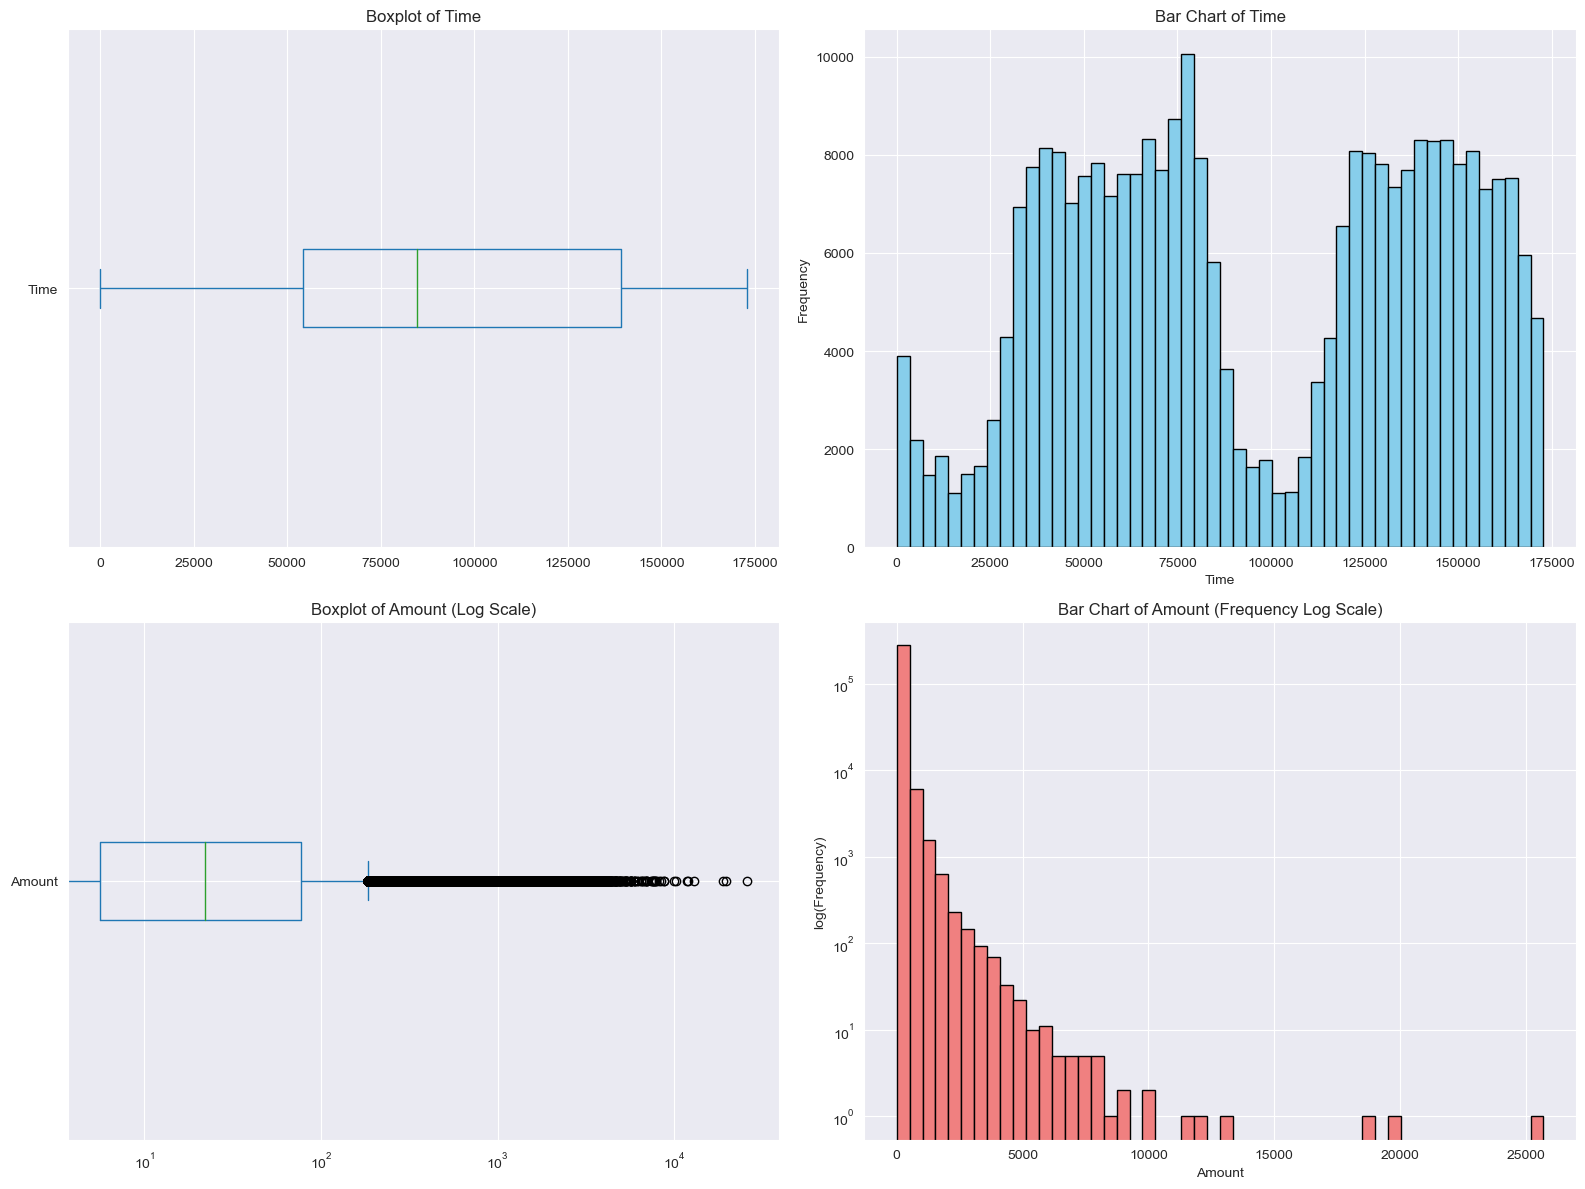

In [11]:
# Create subplots for both boxplots and bar charts
plt.figure(figsize=(16, 12))

# Boxplot for 'Time'
plt.subplot(2, 2, 1)
df['Time'].plot(kind='box', vert=False)
plt.title('Boxplot of Time')

# Bar chart for 'Time'
plt.subplot(2, 2, 2)
df['Time'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Bar Chart of Time')
plt.xlabel('Time')

# Boxplot for 'Amount' (log scale)
plt.subplot(2, 2, 3)
plt.xscale('log')
df['Amount'].plot(kind='box', vert=False)
plt.title('Boxplot of Amount (Log Scale)')

# Bar chart for 'Amount' (Frequency log scale)
plt.subplot(2, 2, 4)
plt.yscale('log')
df['Amount'].plot(kind='hist', bins=50, color='lightcoral', edgecolor='black')
plt.title('Bar Chart of Amount (Frequency Log Scale)')
plt.xlabel('Amount')
plt.ylabel('log(Frequency)')

plt.tight_layout()
plt.show()


<b>Observation: 

- <b>50% of the amount per transaction is between 5.60 and 77.17. But we can see that there's a lot of extreme value: the maximum amount for one transaction was 25691.16.
- <b>We can also see patterns in the number of transactions by 'Time', with peaks and dips regularly.

In [12]:
# Filter the dataset where fraud is detected
fraud_data = df[df['Class'] == 1]


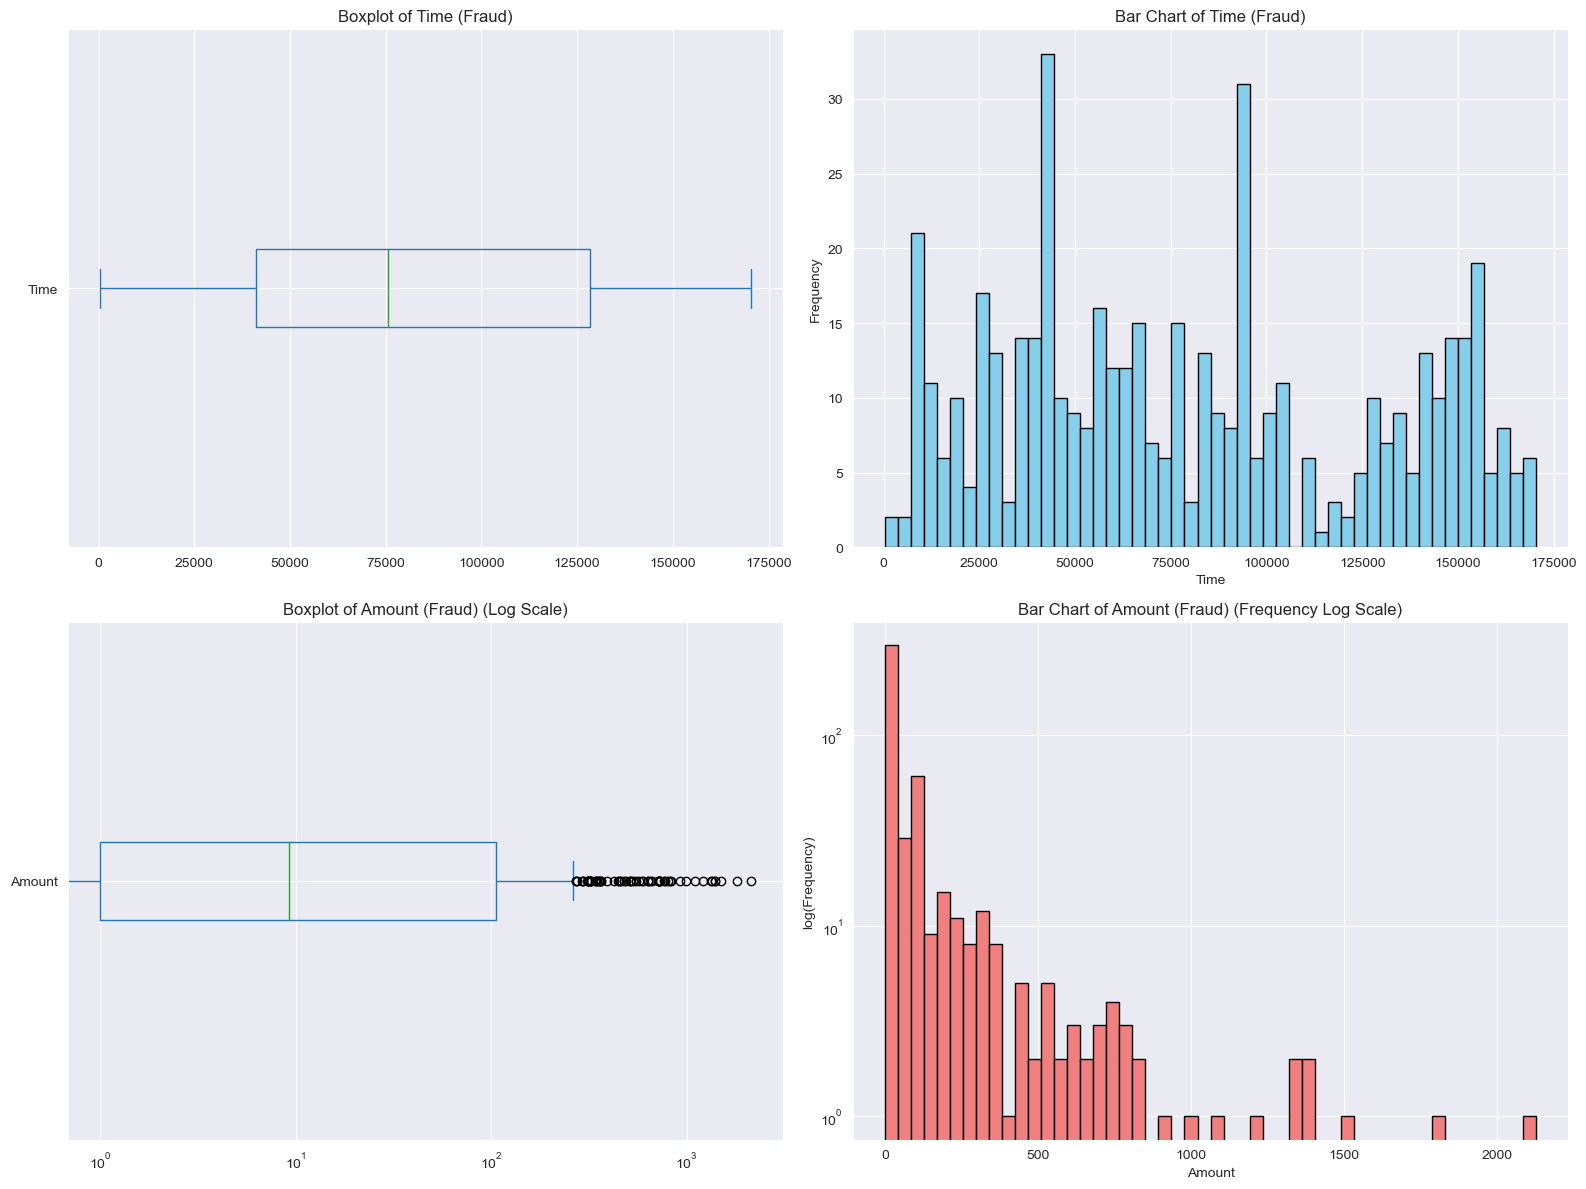

In [13]:
# Filter the dataset for fraudulent transactions
fraud_data = df[df['Class'] == 1]

# Create subplots for both boxplots and bar charts for fraud data
plt.figure(figsize=(16, 12))

# Boxplot for 'Time' in fraud data
plt.subplot(2, 2, 1)
fraud_data['Time'].plot(kind='box', vert=False)
plt.title('Boxplot of Time (Fraud)')

# Bar chart for 'Time' in fraud data
plt.subplot(2, 2, 2)
fraud_data['Time'].plot(kind='hist', bins=50, color='skyblue', edgecolor='black')
plt.title('Bar Chart of Time (Fraud)')
plt.xlabel('Time')

# Boxplot for 'Amount' in fraud data (log scale)
plt.subplot(2, 2, 3)
plt.xscale('log')
fraud_data['Amount'].plot(kind='box', vert=False)
plt.title('Boxplot of Amount (Fraud) (Log Scale)')

# Bar chart for 'Amount' in fraud data (Frequency log scale)
plt.subplot(2, 2, 4)
plt.yscale('log')
fraud_data['Amount'].plot(kind='hist', bins=50, color='lightcoral', edgecolor='black')
plt.title('Bar Chart of Amount (Fraud) (Frequency Log Scale)')
plt.xlabel('Amount')
plt.ylabel('log(Frequency)')

plt.tight_layout()
plt.show()


<b>Observation: 
- <b>When filtering the dataset and selecting frauds, no clear trend can be seen between frauds and the 'Time' and 'Amount' columns. Fraudsters tend to keep amounts under the radar.
- <b>The bar chart for 'Time' when there is a fraud is not the same look than the bar chart for all the class.

<b>It would be interesting to redo these graphs but replace the variable 'Time' with the variable 'Hour'.

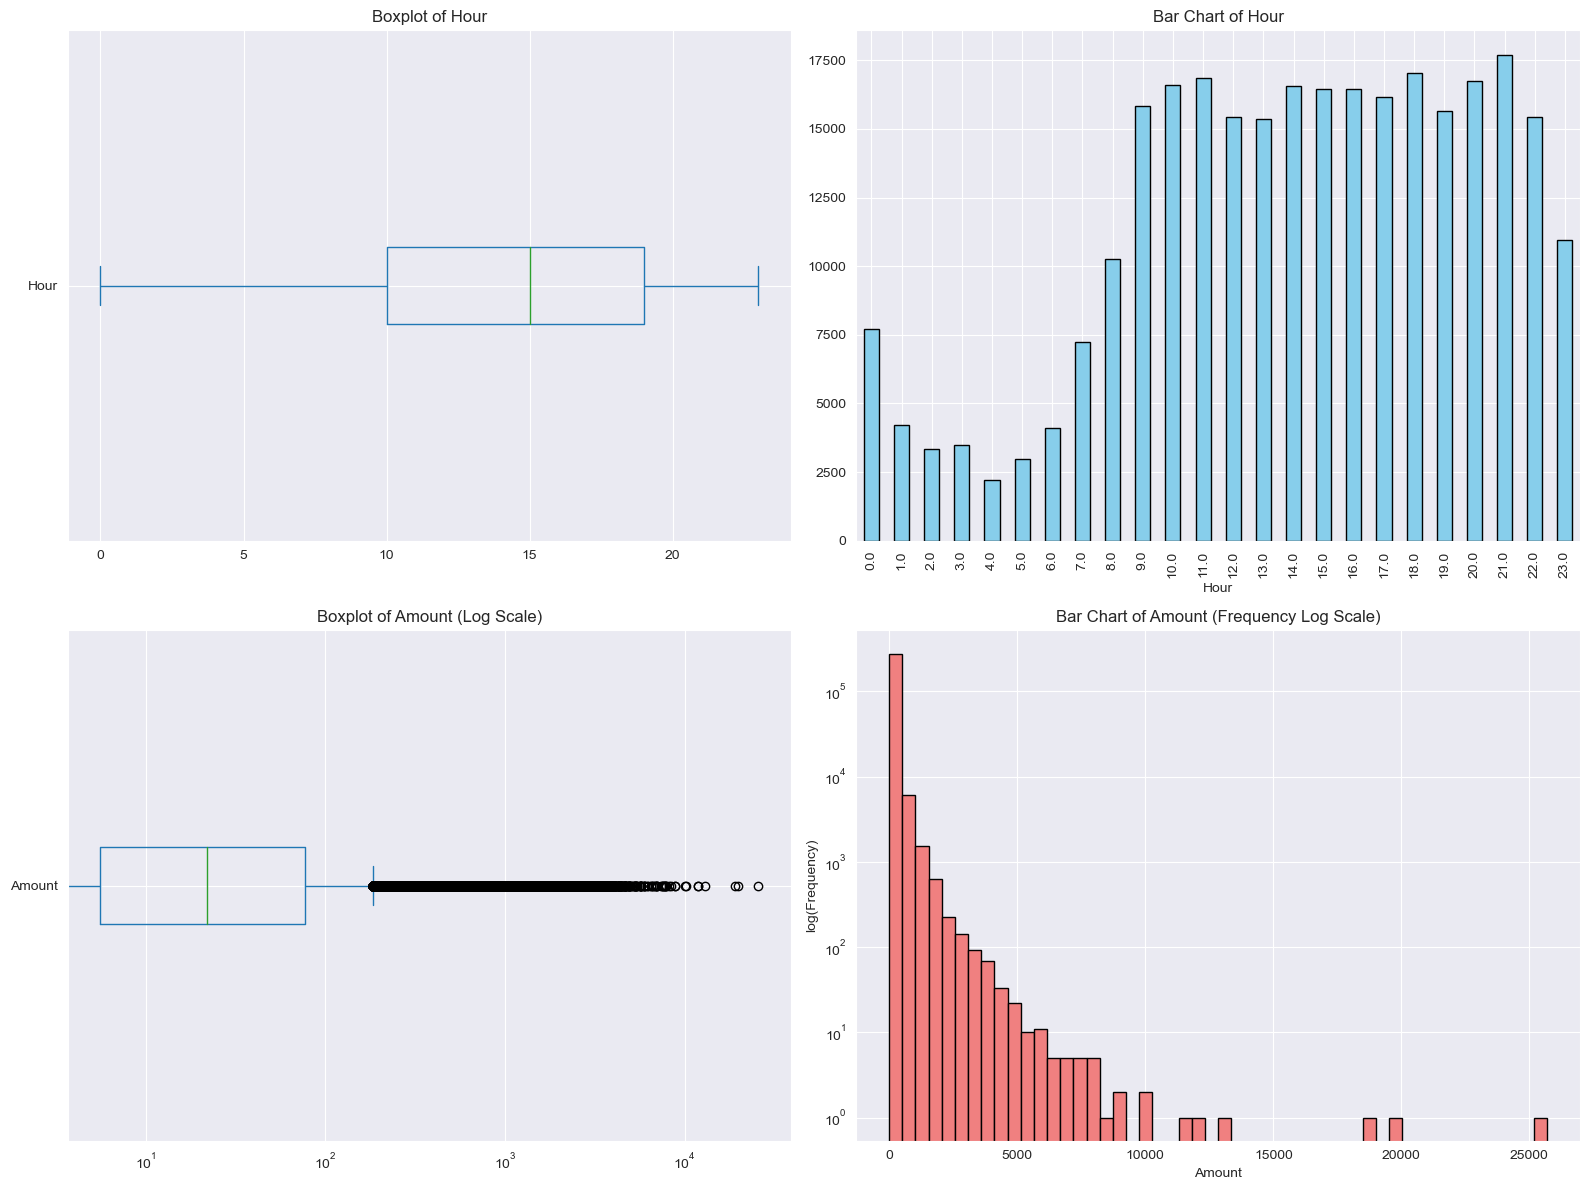

In [14]:
# Create subplots for both boxplots and bar charts
plt.figure(figsize=(16, 12))

# Boxplot for 'Hour'
plt.subplot(2, 2, 1)
df['Hour'].plot(kind='box', vert=False)
plt.title('Boxplot of Hour')

# Bar chart for 'Hour'
plt.subplot(2, 2, 2)
df['Hour'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar Chart of Hour')
plt.xlabel('Hour')

# Boxplot for 'Amount' (log scale)
plt.subplot(2, 2, 3)
plt.xscale('log')
df['Amount'].plot(kind='box', vert=False)
plt.title('Boxplot of Amount (Log Scale)')

# Bar chart for 'Amount' (Frequency log scale)
plt.subplot(2, 2, 4)
plt.yscale('log')
df['Amount'].plot(kind='hist', bins=50, color='lightcoral', edgecolor='black')
plt.title('Bar Chart of Amount (Frequency Log Scale)')
plt.xlabel('Amount')
plt.ylabel('log(Frequency)')

plt.tight_layout()
plt.show()


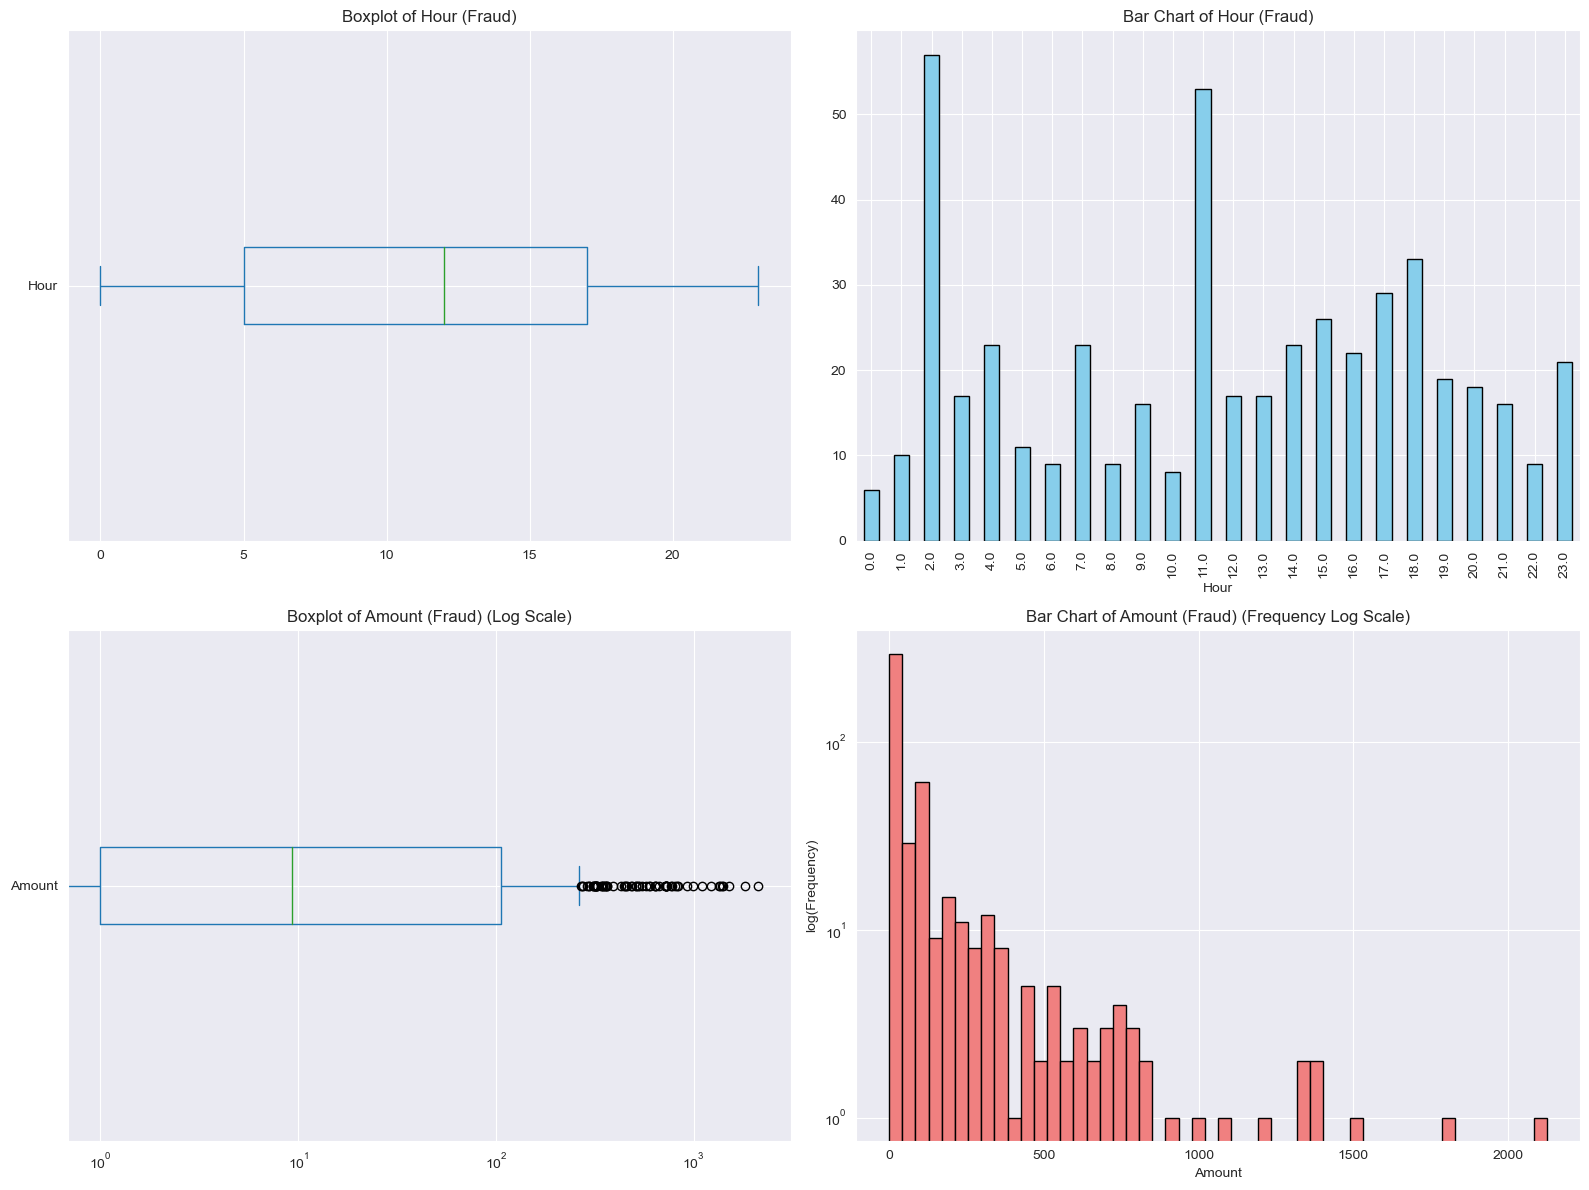

In [15]:
# Create subplots for both boxplots and bar charts for fraud data
plt.figure(figsize=(16, 12))

# Boxplot for 'Hour' in fraud data
plt.subplot(2, 2, 1)
fraud_data['Hour'].plot(kind='box', vert=False)
plt.title('Boxplot of Hour (Fraud)')

# Bar chart for 'Hour' in fraud data
plt.subplot(2, 2, 2)
fraud_data['Hour'].value_counts().sort_index().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Bar Chart of Hour (Fraud)')
plt.xlabel('Hour')

# Boxplot for 'Amount' in fraud data (log scale)
plt.subplot(2, 2, 3)
plt.xscale('log')
fraud_data['Amount'].plot(kind='box', vert=False)
plt.title('Boxplot of Amount (Fraud) (Log Scale)')

# Bar chart for 'Amount' in fraud data (Frequency log scale)
plt.subplot(2, 2, 4)
plt.yscale('log')
fraud_data['Amount'].plot(kind='hist', bins=50, color='lightcoral', edgecolor='black')
plt.title('Bar Chart of Amount (Fraud) (Frequency Log Scale)')
plt.xlabel('Amount')
plt.ylabel('log(Frequency)')

plt.tight_layout()
plt.show()


<b>Observation: 
- <b>By analyzing the data on a 'Hour' scale, rather than a 'Time' scale, we can see even more clearly the troughs in transactions during the day, and we can see two times of the day when fraud occurs more: at two o'clock and at 11 o'clock. 
- <b>Is this a coincidence? Are the frauds programmed to be carried out at a particular time?

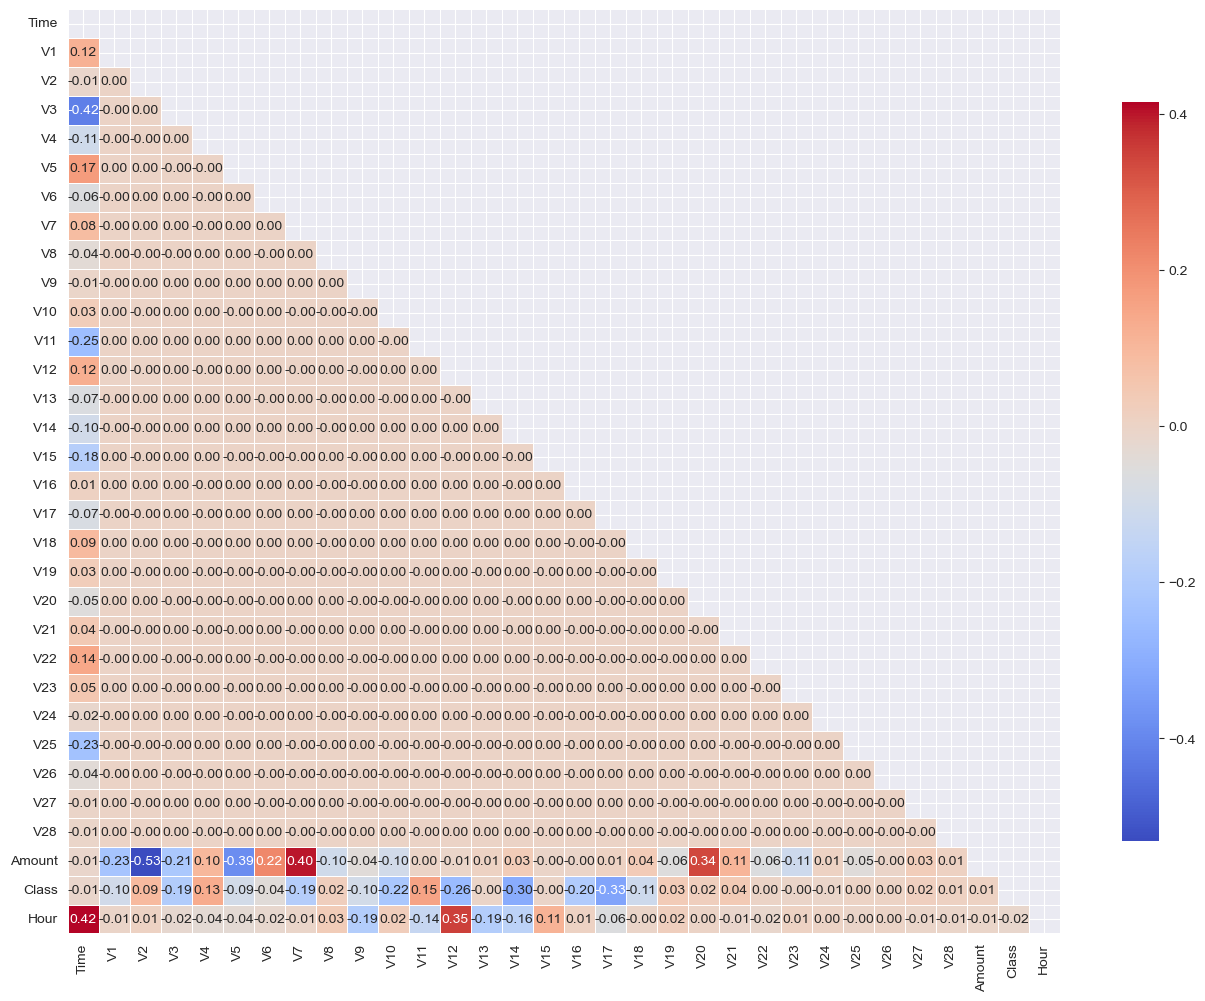

In [16]:
# Correlation matrix
corr = df.corr()

# Mask the upper triangle the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))

# Create the heatmap
plt.figure(figsize=(16, 12))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f', mask=mask, linewidths=0.5, cbar_kws={'shrink': 0.8})

# Improve readability of the labels
plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()


<b>Obsevation: 
- <b>There is no correlation between the 'Class' variable and the 'Amount', 'Time' and 'Hour' variables.
- <b>There is a correlation between the variable 'Class' and the variables 'V2', 'V4' and 'v11'. And a decorrelationship with variables 'V3', 'V7', 'V10', 'V12', 'V14', 'V17'.
- <b>We can see a correlation between the variable 'Amount' and the variables 'V7' and 'V20'. And a decorrelation with variables 'V2' and 'V5'.
- ...

# Preprocessing

## Data cleaning

The data is already cleaned, there are no errors or inconsistencies, there are no missing values, the column types are correct, no need for one-hot encoding on the class column.

## Standardization

In [17]:
# Log the 'Amount column' before standardize
df['Amount'] = np.log1p(df['Amount'])


In [18]:
# Scale 'Amount' and 'Hour' column
scaler = StandardScaler()

df['Amount_scaled'] = scaler.fit_transform(df[['Amount']])
df['Hour_scaled'] = scaler.fit_transform(df[['Hour']])


In [19]:
# Drop old columns and print the result
df.drop(columns=['Amount', 'Hour', 'Time'], inplace=True)
print(df.head())


         V1        V2        V3        V4        V5        V6        V7  \
0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9       V10  ...       V22       V23       V24       V25  \
0  0.098698  0.363787  0.090794  ...  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425 -0.166974  ... -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  0.207643  ...  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024 -0.054952  ...  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  0.753074  ...  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28  Class  Amount_scaled  Hour_scaled  

# Model Development

<b>Given that the dataset is imbalanced, we will evaluate our model using the confusion matrix, ROC AUC score, and AUPRC score.
Since we are working with sensitive financial data, we require an explainable model. Therefore, we will try three models which does not use neural networks: XGBoost classifier, Logistic Regression, and Random Forest.

In [20]:
X = df.drop(columns=['Class'], axis=1)
y = df['Class']


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


## XGBoost

In [23]:
# Addressing the imbalance problem using the scale pos weight method
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print("Scale pos weight =", scale_pos_weight)


Scale pos weight = 577.2868020304569


In [24]:
model_XGB = XGBClassifier(
    scale_pos_weight=scale_pos_weight,
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    eval_metric='logloss'
)

model_XGB.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [25]:
# Evaluation
y_pred = model_XGB.predict(X_test)
y_proba = model_XGB.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))
auprc = average_precision_score(y_test, y_proba)
print(f"AUPRC Score: {auprc:.4f}")


Confusion Matrix:
 [[56726   138]
 [   12    86]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.38      0.88      0.53        98

    accuracy                           1.00     56962
   macro avg       0.69      0.94      0.77     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9798714153641197
AUPRC Score: 0.8412


## Random Forest

In [32]:
model_RF = RandomForestClassifier(n_estimators=5, class_weight='balanced', random_state=42)
model_RF.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=5, random_state=42)

In [33]:
# Evaluation
y_pred = model_RF.predict(X_test)
y_proba = model_RF.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))
auprc = average_precision_score(y_test, y_proba)
print(f"AUPRC Score: {auprc:.4f}")


Confusion Matrix:
 [[56864     0]
 [   25    73]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       1.00      0.74      0.85        98

    accuracy                           1.00     56962
   macro avg       1.00      0.87      0.93     56962
weighted avg       1.00      1.00      1.00     56962


ROC AUC Score: 0.9232986438103661
AUPRC Score: 0.8209


## Logistic Regression

In [28]:
model_LR = LogisticRegression(class_weight='balanced', random_state=42)
model_LR.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', random_state=42)

In [29]:
# Evaluation
y_pred = model_LR.predict(X_test)
y_proba = model_LR.predict_proba(X_test)[:, 1]
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_proba))
auprc = average_precision_score(y_test, y_proba)
print(f"AUPRC Score: {auprc:.4f}")


Confusion Matrix:
 [[55433  1431]
 [    9    89]]

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.97      0.99     56864
           1       0.06      0.91      0.11        98

    accuracy                           0.97     56962
   macro avg       0.53      0.94      0.55     56962
weighted avg       1.00      0.97      0.99     56962


ROC AUC Score: 0.9792498105038301
AUPRC Score: 0.7274
